# Inverting evolution for Ising model
The goal is to obtain the inverse evolution: $e^{-itH}\to e^{itH}$

In [1]:
from simple_exact_diagonalization_routines.local_matrix_class import *
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from class_ising_model import *
import itertools
from class_double_bracket_flow import *
import math

## Nearest-neighbor

### Test 1: 1D Nearest neighbor
First, we observe that for a nearest-neighbor model $H_{NN} = \sum_i Z_i Z_{i+1}$, $X_{odd} = \prod_i X_{2i-1}$, satisfies:

   \begin{align}
        X_\text{odd} H_\text{NN}X_\text{odd} =-H_\text{NN}
    \end{align}

In the 4 qubit case:

$H_{NN} = Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4$

$H_{odd} = X_1X_3$

$H_{odd}H_{NN}H_{odd} = -Z_1Z_2 - Z_2Z_3 - Z_3Z_4$

In [60]:
# Test: class output correct Hamiltonian, J_class = '1D' by default
# # H_NN = Z1Z2 + Z2Z3 + Z3Z4

sys_1D = ising_model([0,0,0,0],[0,0,0,0])
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(2) + sys_1D.Z.at(2) @ sys_1D.Z.at(3) + sys_1D.Z.at(3) @ sys_1D.Z.at(4)))

True


In [63]:
X_odd_list = [sys_1D.X.at(2*i + 1) for i in range(math.ceil(sys_1D.L/2))]
X_odd = np.linalg.multi_dot(X_odd_list)
print(np.all(X_odd == sys_1D.X.at(1)@sys_1D.X.at(3)))
print(np.all(X_odd @ sys_1D.H @ X_odd ==-sys_1D.H))

True
True


### Test 2: Circular NN (Even L)
$H_{NN} = Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4 + Z_4Z_1$

$H_{odd} = X_1X_3$

$H_{odd}H_{NN}H_{odd} = -Z_1Z_2 - Z_2Z_3 - Z_3Z_4 - Z_4Z_1$

In [64]:
# Test: class output correct Hamiltonian, J_class = 'custom' and 'circular'
# # H_NN = Z1Z2 + Z2Z3 + Z3Z4 + Z4Z1

# sys = ising_model([0,0,0],[0,0,0],J_type='custom',J_custom={(1,2):1, (2,3):1, (1,3):1})
sys_circ = ising_model([0,0,0,0],[0,0,0,0],J_type='circular')
print(np.all(sys_circ.H == sys_circ.Z.at(1) @ sys_circ.Z.at(2) + sys_circ.Z.at(2) @ sys_circ.Z.at(3) + sys_circ.Z.at(3) @ sys_circ.Z.at(4) + sys_circ.Z.at(1) @ sys_circ.Z.at(4)))

True


In [67]:
print(np.all(X_odd == sys_circ.X.at(1)@sys_circ.X.at(3)))
print(np.all(X_odd @ sys_circ.H @ X_odd ==-sys_circ.H))

True
True


## Next-nearest-neighbor

### Test 1: 1D NNN
$H_{NNN} = Z_1 Z_2 + .5Z_1 Z_3 + Z_2 Z_3 + .5Z_2 Z_4 + Z_3 Z_4$

$H_{odd} = X_1X_3$

$H_{odd}H_{NNN}H_{odd} = ...$


In [16]:
sys_1D = ising_model([0,0,0,0],[0,0,0,0],max_coupling_range=2)
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(2) + .5*sys_1D.Z.at(1) @ sys_1D.Z.at(3)\
    + sys_1D.Z.at(2) @ sys_1D.Z.at(3) + .5*sys_1D.Z.at(2) @ sys_1D.Z.at(4) + sys_1D.Z.at(3) @ sys_1D.Z.at(4)))
X_odd = sys_1D.X_odd()
X_cor = sys_1D.X.at(1) @ sys_1D.X.at(2)
print(np.all(X_odd @ sys_1D.H @ X_odd == sys_1D.H))
print(np.all(X_cor @ sys_1D.H @ X_cor == -sys_1D.H))

True
False
False


In [13]:
sys_1D = ising_model([0,0,0,0],[0,0,0,0],max_coupling_range=2)
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(3) + sys_1D.Z.at(2) @ sys_1D.Z.at(4)))
X_odd = sys_1D.X_odd()
X_cor = sys_1D.X.at(1) @ sys_1D.X.at(2)
print(np.all(X_odd @ sys_1D.H @ X_odd == sys_1D.H))
print(np.all(X_cor @ sys_1D.H @ X_cor == -sys_1D.H))

False
False
False


## H with field
$H  = Z_1Z_2 + \frac{1}{2}Z_1Z_3 + Z_2Z_3$

$H_{inverter} = X_2$

$H_{inverter} H H_{inverter} = -H + Z_1Z_3$

In [274]:
# Basic case
sys = ising_model([0,0,0], [0,0,0], max_coupling_range=2)
H_inverter = sys.X.at(2)
H_imp_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_imp_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3))))
print(np.all(H_imp_inv + sys.H == sys.Z.at(1)@sys.Z.at(3)))

True
True


### Convergence
$\lang e^{itH}, \mathcal I(e^{-itH})\rang = tr(e^{-itH} X_2e^{-itH}X_2e^{it Z_1Z_3})=tr(e^{-itH} e^{it(Z_1Z_2+Z_2 Z_3 - \frac{1}{2}Z_1Z_3)}e^{it Z_1Z_3})$

In [289]:
# Convergence
def imperfect_inversion_evolution(H, H_inverter, t, N):
    # Returns approximated e^itH with trotterization
    H_imp_inv = H_inverter @ H @ H_inverter
    missing_term = H_imp_inv + H
    s = t/N
    return np.linalg.matrix_power(((H_inverter @ expm(-1j*s*H) @ H_inverter) @ expm(1j* s *missing_term)), N)
    
def convergence(H, H_inverter,t, N):
    target = expm(-1j*t*H) @ imperfect_inversion_evolution(H, H_inverter, t, N)
    return np.abs(target.trace()/np.sqrt(np.size(H)))

In [290]:
N_list = np.linspace(1,1001,21)
convergence_list = [convergence(sys.H, H_inverter, 1, int(N)) for N in N_list]
print(convergence_list)
# No clear trend

[0.4208290181660961, 0.9985513679934538, 0.9996304700369318, 0.999834661059686, 0.9999066853464738, 0.9999401587684638, 0.9999583880331733, 0.9999693987634526, 0.9999765541627179, 0.9999814645860837, 0.9999849796327711, 0.9999875819537761, 0.99998956222619, 0.9999911039928405, 0.9999923277757887, 0.9999933153661107, 0.999994123853613, 0.9999947940661231, 0.9999953558281773, 0.9999958313357244, 0.9999962373843128]


$H  = Z_1Z_2 + \frac{1}{2}Z_1Z_3 + Z_2Z_3 +Z_1 + Z_2 + Z_3 + 2(X_1 + X_2 + X_3)$

$H_{inverter} = Y_1Y_3$

$H_{inverter} H H_{inverter} = -H + Z_1Z_3+2Z_2+4X_2$

In [291]:
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_imp_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_imp_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


[0.4208290181660961, 0.9001324857234819, 0.9692521506428866, 0.9853634271416382, 0.9914812835306365, 0.994435752407034, 0.9960832204084248, 0.9970944350527611, 0.9977592781350435, 0.9982195777882122, 0.9985513679934538, 0.9987983808813581, 0.9989872151941835, 0.9991348019968949, 0.9992523337046184, 0.9993474490838816, 0.999425505903673, 0.9994903519699658, 0.9995448083939625, 0.9995909815937039, 0.9996304700369318]


Text(0, 0.5, 'Convergence trace')

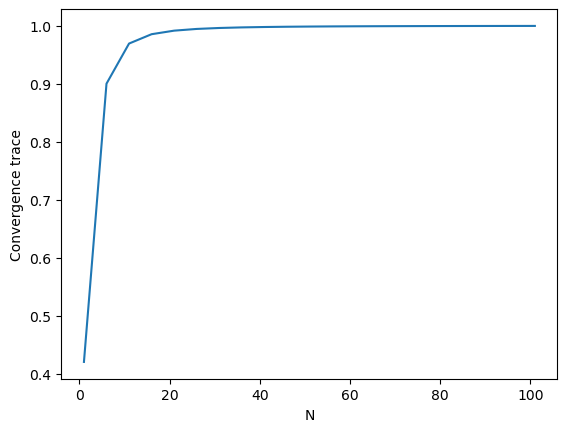

In [292]:
N_list = np.linspace(1,101,21)
convergence_list = [convergence(sys.H, H_inverter, 1, int(N)) for N in N_list]
print(convergence_list)
plt.plot(N_list, convergence_list)
plt.xlabel('N')
plt.ylabel('Convergence trace')

# DBI integration

## Test: group commutator approximation

### Without imperfect inversion
$e^{-s[\hat D,\hat J]} = e^{i\sqrt s \hat D}e^{i\sqrt s\hat J}e^{-i\sqrt s \hat D}e^{-i\sqrt s\hat J}+ \hat E^{\text{(GC)}}$

$E(GC)\le \frac{1}{2}s^\frac{3}{2}(||[D, [D,J]]||+||[J, [D,J]]||)$
- Here we use operator norm (max SVD value)

In [280]:
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_impf_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_impf_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


In [304]:
def commutator(A, B):
    return A.dot( B ) - B.dot( A )

def group_commutator(D , H, s, H_inverter=None, N=2):
    # Returns e^(-s[D,H])
    sqrt_s = np.sqrt(s)
    if np.any(H_inverter) == None:
        return expm(1j*sqrt_s*D) @ expm(1j*sqrt_s*H) @ expm(-1j*sqrt_s*D) @ expm(-1j*sqrt_s*H)
    else:
        # print('GC calculated via imperfect inversion')
        return expm(1j*sqrt_s*D) @ imperfect_inversion_evolution(H, H_inverter, sqrt_s, N) @ expm(-1j*sqrt_s*D) @ expm(-1j*sqrt_s*H)

def delta( A ):
        return np.diag( A.diagonal() )

In [260]:
def op_norm(op):
    U, s, Vh = np.linalg.svd(op)
    return max(s)

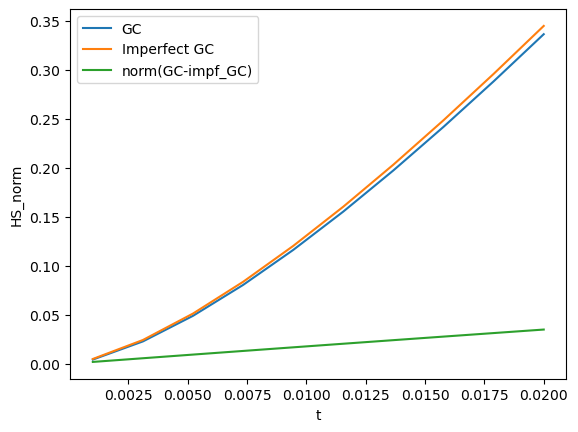

In [307]:
t_list = np.linspace(0.001, 0.02, 10)
norm_list_linear = []
norm_list_GC = []
norm_list_impf_GC = []
norm_list_diff_GC = []
bound_list = []
D = delta(sys.H)
N = 5
bound = op_norm(commutator(D, commutator(D, sys.H)))\
            + op_norm(commutator(sys.H, commutator(D, sys.H)))
for t in t_list:
    GC = group_commutator(D, sys.H, t)
    impf_GC = group_commutator(D, sys.H, t, H_inverter, N=N)
    exp_commutator = expm(-t * commutator(D, sys.H))
    diff_GC = exp_commutator - GC
    diff_impf_GC = exp_commutator - impf_GC
    diff_GC_impf_GC = GC - impf_GC
    norm_diff_GC = op_norm(diff_GC)
    norm_diff_impf_GC = op_norm(diff_impf_GC)
    norm_list_linear.append( op_norm(GC - np.eye(2**sys.L) + t * commutator(D, sys.H)))
    norm_list_GC.append(norm_diff_GC)
    norm_list_impf_GC.append(norm_diff_impf_GC)
    norm_list_diff_GC.append(op_norm(diff_GC_impf_GC))
    bound_list.append(.5*bound*(t**1.5))
# plt.plot(t_list, norm_list_linear,label='Linear')
plt.plot(t_list, norm_list_GC,label='GC')
plt.plot(t_list, norm_list_impf_GC,label='Imperfect GC')
plt.plot(t_list, norm_list_diff_GC,label='norm(GC-impf_GC)')
# plt.plot(t_list, bound_list, label='Error bound')
plt.xlabel('t')
plt.ylabel('HS_norm')
plt.legend()

## DBF with GC

In [3]:
# System set up
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_impf_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_impf_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


In [4]:
H_LRIM = sys.H
flow = double_bracket_flow( H_LRIM )
flow.please_use_group_commutator = True
flow.flow_generator['type'] = 'prescribed'
flow.flow_generator['operator'] = flow.delta(H_LRIM)
flow.trotter_steps = 10

In flow forwards continuing with the previous flowed H
Flow step  0  using H with norm  11.74734012447073
    Found minimum norm =  6.975014234757841  for s =  0.12121212121212122
Flow step  1  using H with norm  11.747340124470734
    Found minimum norm =  6.5537761064054445  for s =  0.020202020202020204
Flow step  2  using H with norm  11.747340124470728
    Found minimum norm =  6.321805624463071  for s =  0.020202020202020204
Flow step  3  using H with norm  11.747340124470727
    Found minimum norm =  6.105814157545193  for s =  0.020202020202020204
Flow step  4  using H with norm  11.747340124470725
    Found minimum norm =  5.714750722860958  for s =  0.04040404040404041
Flow step  5  using H with norm  11.747340124470725
    Found minimum norm =  5.161310664825859  for s =  0.020202020202020204
Flow step  6  using H with norm  11.747340124470727
    Found minimum norm =  4.620987286538534  for s =  0.020202020202020204
Flow step  7  using H with norm  11.74734012447073
    Fou

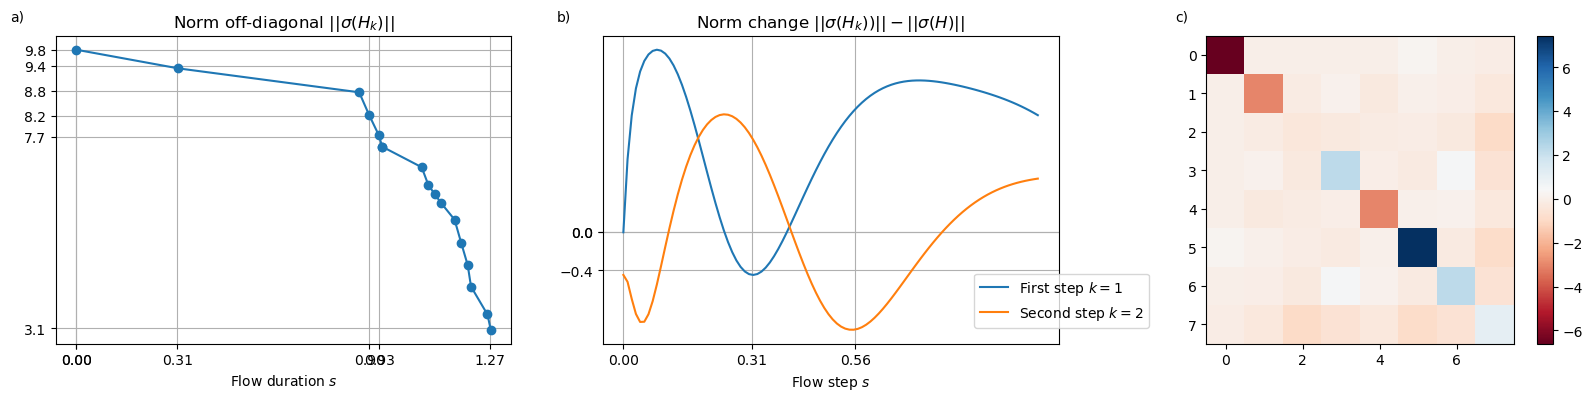

In [6]:
flow.please_be_exhaustively_verbose = False
flow.please_be_verbose = True

flow.nmb_search_points_minimizing_s_search = 100
flow.flow_step_max = 1
flow.nmb_flow_steps = 10
flow.please_use_binary_search =  False
flow.please_compute_observables = False
flow.flow_forwards( )


flow.show_flow_forwards_results()
# Here plot c: real values


## DBF with imperfect GC

In [2]:
# System set up
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_impf_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_impf_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


In [3]:
H_LRIM = sys.H
flow = double_bracket_flow( H_LRIM )
flow.please_use_imperfect_group_commutator = True
flow.flow_generator['type'] = 'prescribed'
flow.flow_generator['operator'] = flow.delta(H_LRIM)
flow.inverter = H_inverter
flow.trotter_steps = 10

Flow step  0  using H with norm  11.74734012447073
    Found minimum norm =  9.43944661954228  for s =  0.31313131313131315
Flow step  1  using H with norm  11.747340124470721
    Found minimum norm =  9.160064679349674  for s =  0.04040404040404041
Flow step  2  using H with norm  11.747340124470702
    Found minimum norm =  8.19894004172107  for s =  0.030303030303030304
Flow step  3  using H with norm  11.747340124470707
    Found minimum norm =  6.729765717995632  for s =  0.04040404040404041
Flow step  4  using H with norm  11.747340124470723
    Found minimum norm =  6.19364853945934  for s =  0.020202020202020204
Flow step  5  using H with norm  11.747340124470735
    Found minimum norm =  6.040509131712074  for s =  0.020202020202020204
Flow step  6  using H with norm  11.747340124470742
    Found minimum norm =  5.996454968604547  for s =  0.010101010101010102
Flow step  7  using H with norm  11.747340124470728
    Found minimum norm =  5.986798969297541  for s =  0.0101010101

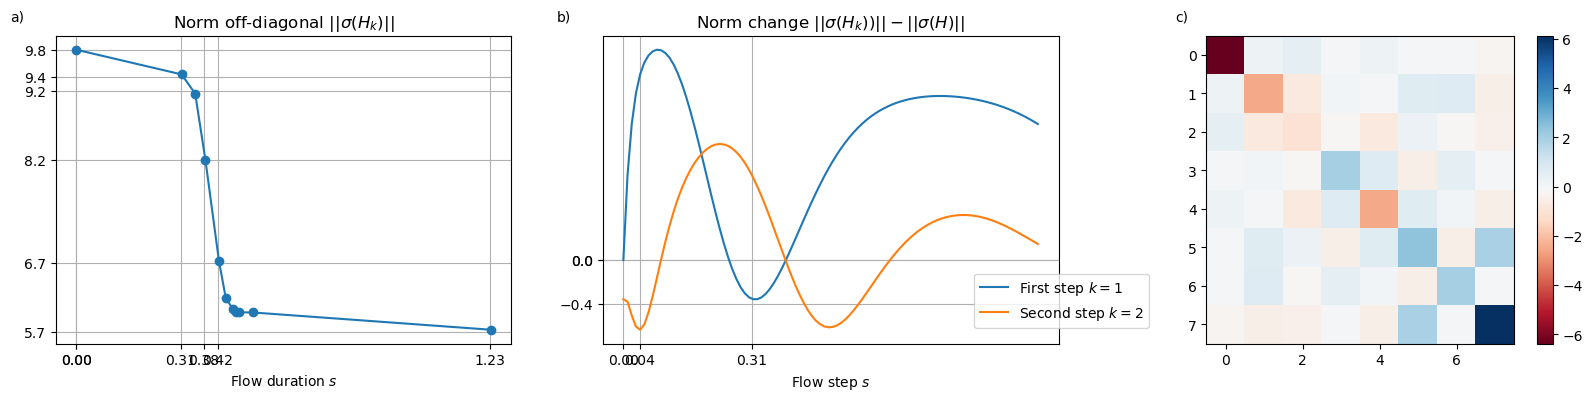

In [4]:
flow.please_be_exhaustively_verbose = False
flow.please_be_verbose = True

flow.nmb_search_points_minimizing_s_search = 100
flow.flow_step_max = 1
flow.nmb_flow_steps = 10
flow.please_use_binary_search =  False
flow.please_compute_observables = False
flow.flow_forwards( )


flow.show_flow_forwards_results()
# Here plot c: real values